In [1]:
# Librerías básicas
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns
sns.set()

# El módulo Statsmodels

Statsmodels es un módulo de Python que ofrece clases y funciones de varios modelos estadísticos, así como pruebas de hipótesis 
y análisis exploratorio de datos. La documentación se encuentra en <a href='https://www.statsmodels.org/stable/index.html'>statsmodels.org</a>. 

In [2]:
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.graphics.tsaplots as sgt
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 

# Fuentes de datos interesantes

## Algunos archivos csv con datos

En <a href='https://github.com/jbrownlee/Datasets.git'>este repositorio de GitHub</a> se encuentran muchos archivos .csv con datos apropiados para ejercicios de aprendizaje de máquina y series de tiempo. En este notebook utilizaremos el archivo 'airline_passengers.csv'.

In [46]:
# df_airline_raw = pd.read_csv('./data/airline_passengers.csv')
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv',index_col='datetime',parse_dates=True)

In [47]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
datetime,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [48]:
df.index = pd.to_datetime(df.index)

# Librería AutoARIMA

In [49]:
%pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [50]:
from pmdarima.arima import auto_arima

In [51]:
auto_arima_model = auto_arima(df['T (degC)'])

In [52]:
auto_arima_model

ARIMA(order=(2, 1, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [53]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                50224
Model:               SARIMAX(2, 1, 5)   Log Likelihood              -57082.607
Date:                Tue, 01 Oct 2024   AIC                         114181.214
Time:                        17:12:22   BIC                         114251.807
Sample:                    01-01-2009   HQIC                        114203.322
                         - 09-24-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9255      0.001   3535.961      0.000       1.924       1.927
ar.L2         -0.9932      0.001  -1859.318      0.000      -0.994      -0.992
ma.L1         -1.6160      0.003   -590.474      0.000      -1.621      -1.611
ma.L2          0.5676      0.005    106.409      0.000       0.557       0.578
ma.L3          0.0424      0.006      6.689      0.000       0.030       0.055
ma.L4          0.0557      0.007      8.355      0.000       0.043       0.069
ma.L5          0.0323      0.004      8.805      0.000       0.025       0.039
sigma2         0.5670      0.002    334.448      0.000       0.564       0.570
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):            140164.28
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

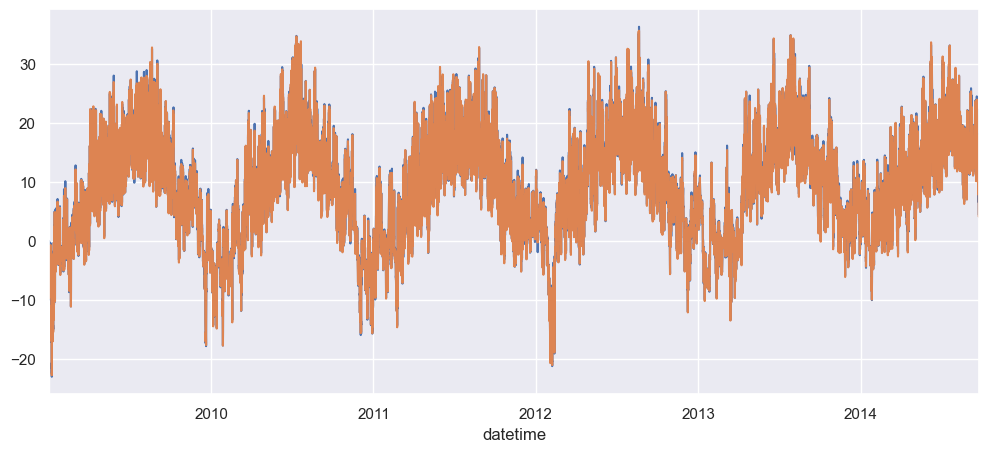

In [56]:
auto_arima_model.predict_in_sample(n_periods=len(df)).plot()
df['T (degC)'].plot(figsize=(12,5));

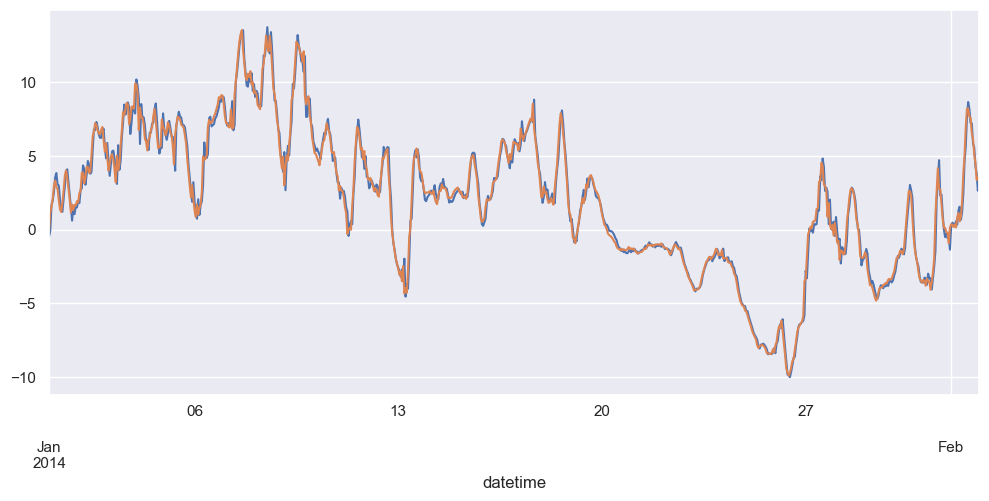

In [60]:
auto_arima_model.predict_in_sample(n_periods=len(df),start='2014-01-01', end = '2014-02-01').plot()
df['T (degC)']['2014-01-01':'2014-02-01'].plot(figsize=(12,5));